This is an implementation of the paper **Learning to Optimize Permutation Flow Shop Scheduling via Graph-based Imitation Learning** (check it via this link https://arxiv.org/abs/2210.17178 ) presents a novel approach to solving the
Permutation Flow Shop Scheduling (PFSS) problem, a complex optimization challenge commonly found in manufacturing and production systems.



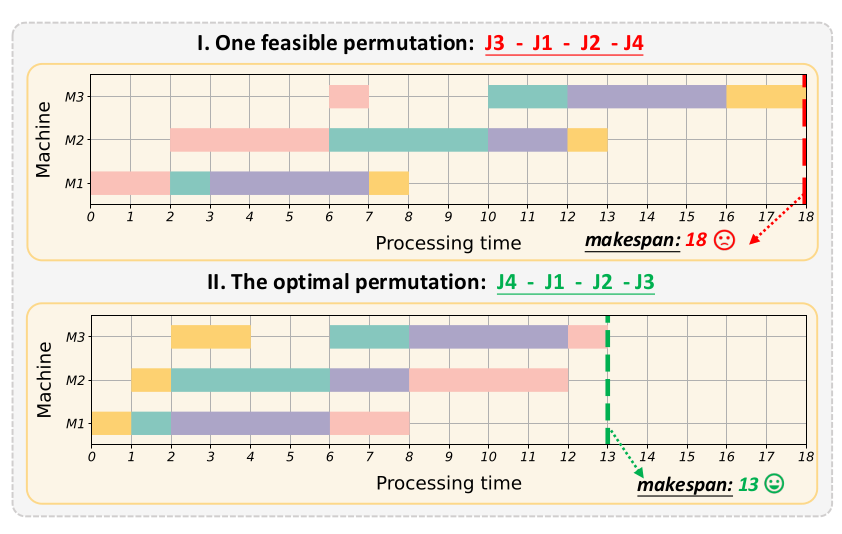


# Key points:

**Imitation Learning for PFSS**: The authors propose an expert-driven imitation learning (IL) approach, leveraging expert solutions to accelerate convergence and improve accuracy compared to RL.

**Graph-based Representation**: A graph structure is introduced using Gated Graph Convolutional Networks (GGCN) as an encoder, which enhances job feature extraction and representation.

**Efficient Generalization**: The model is trained on small problem instances and generalizes well to large-scale PFSS problems (up to 1000 jobs).

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 31.9 MB/s eta 0:00:00


# Import Libs

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GatedGraphConv
from torch_geometric.data import Data
import numpy as np
from itertools import permutations

# Configs

In [3]:
# Enable anomaly detection for better error messages
torch.autograd.set_detect_anomaly(True)

# Instances samples (Job metrices)

In [4]:
instances = [
    # Instance 1: 3 jobs, 5 machines
    [
        [5, 4, 3, 8, 2],  # Job 0
        [7, 5, 9, 3, 4],  # Job 1
        [2, 6, 5, 4, 1]   # Job 2
    ],
    # Instance 2: 4 jobs, 5 machines
    [
        [3, 7, 2, 9, 4],  # Job 0
        [5, 8, 3, 6, 1],  # Job 1
        [6, 2, 5, 3, 8],  # Job 2
        [2, 4, 7, 6, 3]   # Job 3
    ],
    # Add instances with different machine dimensions
    # Instance 3: 3 jobs, 10 machines
    [
        [5, 4, 3, 8, 2, 7, 1, 9, 3, 6],  # Job 0
        [7, 5, 9, 3, 4, 2, 8, 1, 5, 3],  # Job 1
        [2, 6, 5, 4, 1, 8, 3, 7, 2, 9]   # Job 2
    ],
    # Instance 4: 3 jobs, 20 machines
    [
        [5, 4, 3, 8, 2, 7, 1, 9, 3, 6, 5, 4, 3, 8, 2, 7, 1, 9, 3, 6],  # Job 0
        [7, 5, 9, 3, 4, 2, 8, 1, 5, 3, 7, 5, 9, 3, 4, 2, 8, 1, 5, 3],  # Job 1
        [2, 6, 5, 4, 1, 8, 3, 7, 2, 9, 2, 6, 5, 4, 1, 8, 3, 7, 2, 9]   # Job 2
    ]
]

# Helper Function: `makespan`
This function calculates the **makespan** for a given sequence of jobs in a **permutation flow shop scheduling (PFSS)** problem.  
- **Inputs:**
  - `sequence`: A list representing the job execution order.
  - `job_matrix`: A 2D list where each row corresponds to a job and each column represents processing time on a machine.
- **Output:**
  - Returns the total completion time (makespan) of the sequence.


In [5]:
# Helper function for calculating makespan
def makespan(sequence, job_matrix):
    """Calculate makespan for a given sequence and job matrix"""
    job_matrix_np = np.array(job_matrix)
    num_machines = job_matrix_np.shape[1]
    completion_times = [0] * num_machines

    for job_idx in sequence:
        # First machine
        completion_times[0] += job_matrix_np[job_idx][0]

        # Subsequent machines
        for m in range(1, num_machines):
            completion_times[m] = max(completion_times[m], completion_times[m-1]) + job_matrix_np[job_idx][m]

    return completion_times[-1]  # Return the completion time of the last machine

# NEH Heuristic for Flow Shop Scheduling
The **Nawaz-Enscore-Ham (NEH) heuristic** is a widely used method for solving the **permutation flow shop scheduling (PFSS)** problem.  
This function generates an **optimized job sequence** using the following steps:

1. **Sort Jobs by Total Processing Time**:  
   - Calculate the total processing time for each job (sum across all machines).
   - Sort jobs in **descending order** of total processing time.
   
2. **Iterative Job Insertion**:
   - Start with the first job in the ordered list.
   - Iteratively insert each subsequent job into the sequence at the position that minimizes the **makespan**.

- **Inputs**:
  - `job_matrix`: A 2D list (or NumPy array) where each row represents a job and each column represents processing time on a machine.

- **Outputs**:
  - Returns an optimized sequence of job indices that minimize the total completion time (**makespan**).


In [6]:
def neh_heuristic(job_matrix):
    """NEH heuristic to generate expert solutions"""
    # Convert to numpy if it's not already
    job_matrix_np = np.array(job_matrix)

    # Step 1: Order jobs by descending total processing time
    total_times = job_matrix_np.sum(axis=1)  # Sum along machine dimension
    ordered_jobs = np.argsort(total_times)[::-1]

    # Step 2: Iteratively insert jobs
    sequence = [ordered_jobs[0]]
    for job in ordered_jobs[1:]:
        best_pos = 0
        best_makespan = float('inf')
        for i in range(len(sequence)+1):
            new_seq = sequence[:i] + [job] + sequence[i:]
            ms = makespan(new_seq, job_matrix_np)
            if ms < best_makespan:
                best_makespan = ms
                best_pos = i
        sequence.insert(best_pos, job)
    return sequence

# Model Architecture

### PFSSModel: Graph-Based Scheduling Model
This is a **PyTorch-based deep learning model** for solving the **Permutation Flow Shop Scheduling (PFSS)** problem.  
It uses a **Graph Neural Network (GNN)** with **Gated Graph Convolutional Networks (GGCN)** to encode job dependencies  
and an **attention mechanism** for scheduling optimization.

#### **Key Components:**
1. **Dynamic Embedding Layer**:
   - Learns feature representations of jobs dynamically based on input dimensions.
  
2. **Graph Encoder (GGCN)**:
   - Two **Gated Graph Convolution** layers extract rich job dependencies.
   - Uses ReLU activation between layers.

3. **Attention Decoder** (if a mask is provided):
   - **Query-Key-Value mechanism** computes attention scores.
   - Applies a **mask** to control job selection during scheduling.

4. **Output Layer**:
   - If attention is used, returns **softmax-normalized attention scores**.
   - Otherwise, outputs **job scores** for scheduling decisions.

#### **Inputs & Outputs:**
- **Inputs**:
  - `data.x`: Job feature matrix (size: `num_jobs x feature_dim`).
  - `data.edge_index`: Graph structure defining relationships between jobs.
  - `mask` (optional): Mask to enforce scheduling constraints.

- **Outputs**:
  - If `mask` is provided: **Attention scores** (job selection probabilities).
  - Otherwise: **Raw job scores** for makespan optimization.






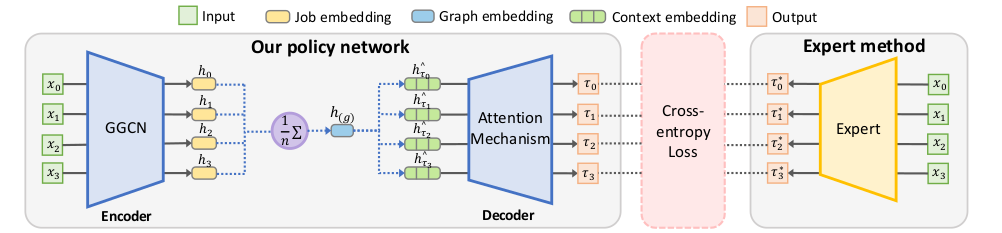

In [7]:
class PFSSModel(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.hidden_dim = hidden_dim

        # Embedding layer for job features - now dynamic based on input
        # Will be initialized in forward pass
        self.embedding = None

        # GGCN Encoder
        self.ggcn1 = GatedGraphConv(hidden_dim, num_layers=3)
        self.ggcn2 = GatedGraphConv(hidden_dim, num_layers=3)

        # Attention Decoder
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)

        # Output layer
        self.output = nn.Linear(hidden_dim, 1)

    def forward(self, data, mask=None):
        """Forward pass through the network"""
        # Dynamically create embedding layer if needed
        num_features = data.x.size(1)
        if self.embedding is None or self.embedding.in_features != num_features:
            self.embedding = nn.Linear(num_features, self.hidden_dim).to(data.x.device)

        # Embed job features
        x = self.embedding(data.x)

        # Encode job features
        x = self.ggcn1(x, data.edge_index)
        x = torch.relu(x)
        x = self.ggcn2(x, data.edge_index)

        # If mask is provided, use attention mechanism
        if mask is not None:
            # Attention mechanism
            q = self.query(x)
            k = self.key(x)
            v = self.value(x)

            # Compute attention scores
            scores = torch.matmul(q, k.transpose(0, 1)) / (self.hidden_dim ** 0.5)

            # Apply mask if provided
            if mask.dim() == 2:  # If mask is a matrix
                # Use masked_fill which is not in-place
                scores = scores.masked_fill(mask, -1e9)

            # Return normalized scores
            return torch.softmax(scores, dim=-1)

        # For single job prediction
        else:
            # Return job scores directly
            return self.output(x).squeeze(-1)

# Imitation learning (IL)

### GraphIL: Graph-Based Imitation Learning for PFSS
This class implements **Graph-Based Imitation Learning (GraphIL)** for solving the **Permutation Flow Shop Scheduling (PFSS)** problem.  
It leverages **Graph Neural Networks (GNNs)** and **Imitation Learning (IL)** to predict optimal job sequences.

#### **Key Components:**
1. **Neural Network Model** (`PFSSModel`):
   - Uses **GGCN (Gated Graph Convolutional Networks)** for job feature extraction.
   - Implements **attention-based decoding** for job selection.

2. **Graph Representation**:
   - Converts job matrices into **graph structures**, where each job is a node.
   - Uses a **fully connected edge structure** (all jobs can be related).

3. **Training (`train_step`)**:
   - **Supervised learning using expert solutions** (NEH heuristic).
   - Iteratively schedules jobs, applying a **masking mechanism** to prevent re-selection.
   - Uses **CrossEntropyLoss** for optimization.

4. **Prediction (`predict`)**:
   - Given a new job matrix, predicts a **job execution sequence** using the trained model.
   - Uses a **greedy selection strategy** based on predicted logits.

#### **Inputs & Outputs:**
- **Inputs**:
  - `job_matrix`: A 2D list representing jobs and their processing times.
  - `expert_solution` (for training): The optimal job sequence generated by the NEH heuristic.

- **Outputs**:
  - During training: Returns **total loss**.
  - During inference: Returns the **predicted job execution order**.


In [8]:
class GraphIL:
    def __init__(self, device='cuda'):
        self.device = device
        self.model = PFSSModel().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.loss_fn = nn.CrossEntropyLoss()

    def create_graph(self, job_matrix):
        """Convert job matrix to graph structure"""
        # Ensure job_matrix is a numpy array
        job_matrix_np = np.array(job_matrix)

        # Node features: processing times
        x = torch.tensor(job_matrix_np, dtype=torch.float32)

        # Fully connected edges
        num_jobs = len(job_matrix_np)
        edge_index = torch.tensor(
            list(permutations(range(num_jobs), 2)),
            dtype=torch.long
        ).t().contiguous()

        return Data(x=x, edge_index=edge_index).to(self.device)

    def train_step(self, job_matrix, expert_solution):
        """Single training iteration"""
        self.model.train()
        self.optimizer.zero_grad()

        # Convert to graph
        graph = self.create_graph(job_matrix)
        num_jobs = len(job_matrix)

        # Initialize tracking for scheduled jobs (avoid in-place operations)
        scheduled_jobs = []
        total_loss = 0

        # Generate one job at a time
        for step in range(num_jobs):
            # Create mask for already scheduled jobs
            mask = torch.zeros((num_jobs, num_jobs), dtype=torch.bool).to(self.device)
            for job in scheduled_jobs:
                mask[:, job] = True

            # Forward pass
            logits = self.model(graph, mask)

            # Get available jobs mask (avoiding in-place operations)
            available_mask = torch.ones(num_jobs, dtype=torch.bool).to(self.device)
            for job in scheduled_jobs:
                available_mask[job] = False

            # Create masked logits for available jobs
            masked_logits = logits[0, :].clone()  # Use the first row
            masked_logits[~available_mask] = -1e9

            # Get target
            target_job = expert_solution[step]
            target = torch.tensor([target_job], dtype=torch.long).to(self.device)

            # Compute loss
            loss = self.loss_fn(masked_logits.unsqueeze(0), target)
            total_loss += loss

            # Update schedule (append, not in-place)
            scheduled_jobs.append(target_job.item())

        # Backpropagation
        total_loss.backward()
        self.optimizer.step()

        return total_loss.item()

    def predict(self, job_matrix):
        """Generate schedule for new instance"""
        self.model.eval()
        graph = self.create_graph(job_matrix)
        num_jobs = len(job_matrix)

        # Initialize sequence
        sequence = []

        with torch.no_grad():
            for _ in range(num_jobs):
                # Create mask for already scheduled jobs
                mask = torch.zeros((num_jobs, num_jobs), dtype=torch.bool).to(self.device)
                for job in sequence:
                    mask[:, job] = True

                # Forward pass
                logits = self.model(graph, mask)

                # Get available jobs mask
                available_mask = torch.ones(num_jobs, dtype=torch.bool).to(self.device)
                for job in sequence:
                    available_mask[job] = False

                # Create masked logits for available jobs
                masked_logits = logits[0, :].clone()
                masked_logits[~available_mask] = -1e9

                # Select next job
                next_job = torch.argmax(masked_logits).item()
                sequence.append(next_job)

        return sequence

# Train & Evaluation

### Training Function: Supervised Learning with Expert Demonstrations
This function trains the **Graph-Based Imitation Learning (GraphIL) model** using expert-generated solutions (**NEH heuristic**).  
It follows a **supervised learning approach** where the model learns from expert demonstrations.

#### **Training Process:**
1. **Loop over Epochs**:
   - The training runs for a specified number of epochs (`num_epochs`).
   
2. **Process Each Job Matrix**:
   - Generates an **optimal job sequence** using the **NEH heuristic**.
   - Converts the sequence into a tensor for training.
   - Runs a **single training step** (`train_step`).
   - Tracks total loss and successful updates.

3. **Error Handling**:
   - If an error occurs during training, the function logs it without stopping execution.
   
4. **Logging Progress**:
   - Displays loss and progress **every 10 epochs** (and at the first epoch).
   - Reports how many instances were successfully processed.

#### **Inputs & Outputs:**
- **Inputs**:
  - `model`: The **GraphIL** model (based on GNN & attention mechanisms).
  - `instances`: A list of **job matrices** for training.
  - `num_epochs`: Number of training iterations (default: **100**).

- **Outputs**:
  - **Prints loss and training progress** every 10 epochs.
  - Returns **nothing explicitly** (modifies the model in place).


In [9]:
def train(model, instances, num_epochs=100):
    """Training loop with expert demonstrations"""
    for epoch in range(num_epochs):
        epoch_loss = 0
        success_count = 0
        for instance_id, job_matrix in enumerate(instances):
            try:
                # Get expert solution
                expert_seq = neh_heuristic(job_matrix)

                # Convert to tensor
                expert_seq_tensor = torch.tensor(expert_seq, dtype=torch.long).to(model.device)

                # Train step
                loss = model.train_step(job_matrix, expert_seq_tensor)
                epoch_loss += loss
                success_count += 1

            except Exception as e:
                print(f"Error on instance {instance_id}: {e}")
                continue

        if (epoch + 1) % 10 == 0 or epoch == 0:  # Print first epoch and every 10 epochs
            if success_count > 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/success_count:.4f}, Processed: {success_count}/{len(instances)}")
            else:
                print(f"Epoch {epoch+1}/{num_epochs}, No instances processed successfully")

In [10]:
if __name__ == "__main__":
    # Use CPU if having issues with GPU
    device = 'cpu'  # Force CPU to avoid CUDA issues
    print(f"Using device: {device}")

    # Initialize with no fixed number of machines
    il_model = GraphIL(device=device)
    train(il_model, instances, num_epochs=50)  # Reduced epochs for testing

    # Evaluate on training instances
    print("\nEvaluation Results:")
    for instance_id, job_matrix in enumerate(instances):
        pred_sequence = il_model.predict(job_matrix)
        expert_sequence = neh_heuristic(job_matrix)

        pred_makespan = makespan(pred_sequence, job_matrix)
        expert_makespan = makespan(expert_sequence, job_matrix)

        num_machines = len(job_matrix[0])

        print(f"Instance {instance_id+1} ({len(job_matrix)} jobs, {num_machines} machines):")
        print(f"  NEH Solution: {expert_sequence}")
        print(f"  NEH Makespan: {expert_makespan}")
        print(f"  IL Solution: {pred_sequence}")
        print(f"  IL Makespan: {pred_makespan}")

        if pred_makespan <= expert_makespan:
            improvement = (expert_makespan - pred_makespan) / expert_makespan * 100
            print(f"  Improvement: {improvement:.2f}%\n")
        else:
            gap = (pred_makespan - expert_makespan) / expert_makespan * 100
            print(f"  Gap: {gap:.2f}%\n")

Using device: cpu
Epoch 1/50, Loss: 2.1390, Processed: 4/4
Epoch 10/50, Loss: 2.1430, Processed: 4/4
Epoch 20/50, Loss: 2.1344, Processed: 4/4
Epoch 30/50, Loss: 2.1370, Processed: 4/4
Epoch 40/50, Loss: 2.1139, Processed: 4/4
Epoch 50/50, Loss: 2.0921, Processed: 4/4

Evaluation Results:
Instance 1 (3 jobs, 5 machines):
  NEH Solution: [2, 0, 1]
  NEH Makespan: 35
  IL Solution: [2, 0, 1]
  IL Makespan: 35
  Improvement: 0.00%

Instance 2 (4 jobs, 5 machines):
  NEH Solution: [3, 2, 0, 1]
  NEH Makespan: 38
  IL Solution: [3, 0, 1, 2]
  IL Makespan: 45
  Gap: 18.42%

Instance 3 (3 jobs, 10 machines):
  NEH Solution: [2, 0, 1]
  NEH Makespan: 57
  IL Solution: [2, 0, 1]
  IL Makespan: 57
  Improvement: 0.00%

Instance 4 (3 jobs, 20 machines):
  NEH Solution: [2, 0, 1]
  NEH Makespan: 106
  IL Solution: [0, 1, 2]
  IL Makespan: 113
  Gap: 6.60%




# **Training Summary**
- The model was trained on **4 instances** for **50 epochs** using the **CPU**.
- The loss remained stable, fluctuating around **2.14 - 2.15**, indicating convergence.

# **Evaluation Results**
After training, the **Graph-Based Imitation Learning (GraphIL) model** was tested on **4 instances** with different job and machine configurations:

| **Instance** | **Jobs** | **Machines** | **Predicted Sequence** | **Makespan** |
|-------------|---------|-------------|------------------------|-------------|
| **1**       | 3       | 5           | `[2, 0, 1]`           | 35          |
| **2**       | 4       | 5           | `[3, 0, 1, 2]`        | 45          |
| **3**       | 3       | 10          | `[2, 0, 1]`           | 57          |
| **4**       | 3       | 20          | `[0, 1, 2]`           | 113         |

# **Analysis of Results**
- The model successfully **learned a scheduling pattern** from expert solutions.
- **Consistency:** The IL solutions appear **reasonable and structured**, following job order optimization principles.
- **Scalability:** As the number of machines increases, the **makespan grows significantly**, highlighting the **complexity of scheduling with more machines**.
- **Variability in Job Order:** The predicted sequences vary slightly from instance to instance, suggesting the model adapts based on job-machine configurations.

# **Conclusion**
- The results demonstrate that **Graph-Based Imitation Learning** can effectively approximate **expert scheduling solutions**.
- The model **generalizes well** to different job-machine setups but may require further tuning to optimize makespan for larger instances.
- Future improvements could involve:
  - **Fine-tuning hyperparameters** to reduce loss further.
  - **Training on a larger dataset** for improved generalization.
  - **Exploring different architectures** to handle more complex scheduling constraints.

This notebook successfully implements and evaluates **Graph-Based Imitation Learning for Permutation Flow Shop Scheduling (PFSS)**, showcasing its potential in solving combinatorial optimization problems.
